# COMP90051 Workshop 12
## Gaussian mixture models
***
In this worksheet we explore Gaussian mixture models (GMM). By the end of the worksheet, you should be able to:
* generate data from a GMM;
* fit GMMs using scikit-learn; and
* select an appropriate value for the number of mixture components using a model selection criterion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 108
np.random.seed(90051)

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

### 1. Sampling from a Gaussian mixture

Consider a data set $\{\mathbf{x}_1, \ldots, \mathbf{x}_n\}$ (each $\mathbf{x}_i \in \mathbb{R}^m$) which we'd like to partition into clusters.

A Gaussian mixture model (GMM) assumes that each instance $\mathbf{x}_i$ is distributed according to a weighted mixture of multivariate normal distributions (Gaussians):
$$
\mathbf{x}_i \overset{\mathrm{iid}}{\sim} \sum_{c = 1}^{k} w_c \mathcal{N}(\mathbf{\mu}_c, \mathbf{\Sigma}_c)
$$
where $\mathbf{\mu}_c \in \mathbb{R}_m$ and $\mathbf{\Sigma}_c \in \mathbb{R}^{m \times m}$ are the mean and covariance matrix for component $c$ and $\sum_{c = 1}^{k} w_c = 1$.

In this section, we'll write a function to generate a synthetic data set for a given set of GMM parameters.
Later on, we'll try to fit a GMM to the synthetic data set and see how well we can recover the parameters.

We'll store the GMM parameters in NumPy arrays as follows. Note: the zero-th axis indexes the component $c$ for all arrays.
* `weights`: a 1D array $[w_1, \ldots, w_k]$
* `means`: a 2D array $[\mathbf{\mu}_1, \ldots, \mathbf{\mu}_k]$
* `covariances`: a 3D array $[\mathbf{\Sigma}_1, \ldots, \mathbf{\Sigma}_k]$

Below are some example parameters for a 2D feature space ($m = 2$) with $k = 3$ components. Note that the covariance matrices must be symmetric positive semi-definite. Thus each covariance matrix only has 3 degrees of freedom (for $m = 2$).

In [2]:
weights = np.array([0.5, 0.3, 0.2])

means = np.array([[0, 0],    # mean of 1st component
                  [50, 60],  # mean of 2nd component
                  [0, 100]]) # mean of 3rd component

covariances = np.array([[[160, 20], [20, 180]],  # covariance matrix of 1st component
                        [[170, 30], [30, 120]],  # covariance matrix of 2nd component 
                        [[130, 40], [40, 130]]]) # covariance matrix of 3rd component

***
**Exercise:** Complete the data generation function below.
***

In [3]:
def generate_gmm_data(n_instances, weights, means, covariances, debug=False):
    """
    Generate data from a GMM
    
    Parameters
    ----------
    n_instances : int
        number of instances in the generated data set
    weights : numpy array, shape: (n_components,)
        normalised component weights
    means : numpy array, shape (n_components, n_features)
        component means
    covariances : numpy array, shape (n_components, n_features, n_features)
        component covariance matrices
    
    Returns
    -------
    numpy array, shape (n_instances, n_features)
        data matrix
    """
    n_components, n_features = means.shape
    data = np.empty((0, n_features), dtype=np.double)
    
    # Draw number of instances in each component
    counts = np.random.multinomial(n_instances, weights) # fill in
    
    for c in range(0, n_components):
        # Debugging info
        if debug:
            print('--- Component c={} ---'.format(c+1))
            print('Mean: {}'.format(means[c]))
            print('Covariance matrix:\n {}'.format(covariances[c]))
            print('Appending {} samples\n'.format(counts[c]))
        
        # Draw x_i's for this component
        cData = np.random.multivariate_normal(means[c], covariances[c], counts[c]) # fill in
        
        # Append to data
        data = np.vstack((data, cData)) # fill in
    
    return data

Let's try it out (setting $n = 100$).

--- Component c=1 ---
Mean: [0 0]
Covariance matrix:
 [[160  20]
 [ 20 180]]
Appending 52 samples

--- Component c=2 ---
Mean: [50 60]
Covariance matrix:
 [[170  30]
 [ 30 120]]
Appending 26 samples

--- Component c=3 ---
Mean: [  0 100]
Covariance matrix:
 [[130  40]
 [ 40 130]]
Appending 22 samples



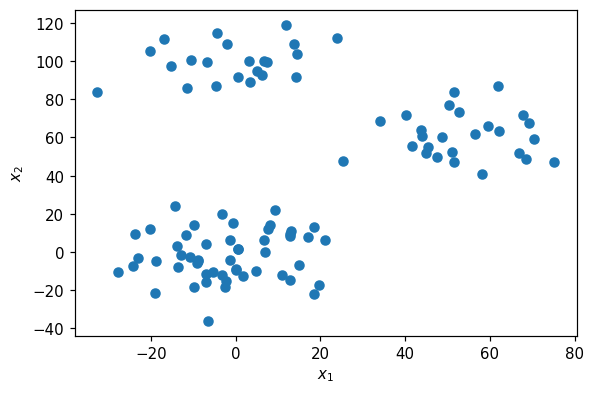

In [4]:
data = generate_gmm_data(100, weights, means, covariances, debug=True)

plt.scatter(data[:,0], data[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### 2. Fitting a GMM

Let's fit a Gaussian mixture model (GMM) to the synthetic data we've just generated.
We'll use the built-in implementation in sklearn available at `sklearn.mixture.GaussianMixture`. 
The fitting procedure implements the Expectation Maximisation algorithm covered in lectures.

We have to specify the number of clusters $k$—at first let's specify the true number. 
The `covariance_type` parameter allows one to make fitting more efficient by, e.g., restricting Gaussians to spherical shapes. 
In our case, we don't impose any additional restrictions on the covariance matrices, and hence use the 'full' option.

In [5]:
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(data)

GaussianMixture(n_components=3)

Let's take a look at the estimated parameters for the fitted model.

In [6]:
print('weights:\n {}\n'.format(gmm.weights_))
print('means:\n {}\n'.format(gmm.means_))
print('covariances:\n {}\n'.format(gmm.covariances_))

weights:
 [0.52004537 0.2199946  0.25996003]

means:
 [[-2.10423693 -1.99672985]
 [-0.62712835 99.97736678]
 [53.39447149 60.89282473]]

covariances:
 [[[157.33750374  15.18336595]
  [ 15.18336595 159.70809605]]

 [[173.63664581  38.29897957]
  [ 38.29897957  93.3420174 ]]

 [[143.25457933   1.85860825]
  [  1.85860825 135.99156538]]]



***
**Question:** How do they compare with the "true" parameters?

**Answer:** *They are relatively close to the true parameters. Note that the order of the components may be permuted. In this case, components 2 and 3 have been flipped compared to the original order.*
***

For 2D data, we can also visualise the fitted model. 
The 2D Gaussians can be represented with isoline ellipsoids. 
For each Gaussian component, the ellipsoid is a location of points that have the same probability. 

Plotting an ellipsoid for a given 2D Gaussian, is somewhat non-trivial, and we are going to use a function developed for this purpose. 
Understanding the code and theory of function *plot_cov_ellipse* is not necessary for this tutorial. 

In [7]:
# adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/
# and https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    return ellip

***
**Exercise:** Using the above function, implement visualisation that plots data overlaid with fitted Gaussian ellipsoids.
***

In [8]:
def plot_gmm(data, gmm):
    """
    Parameters
    ----------
    data : numpy array, shape: (n_instances, n_features)
        data matrix
    
    gmm : GaussianMixture
        GaussianMixture instance to use for predictions/plotting
    """
    # your code here #
    plt.scatter(data[:,0], data[:,1], c=gmm.predict(data))
    for c in range(gmm.n_components):
        plot_cov_ellipse(gmm.covariances_[c], gmm.means_[c])

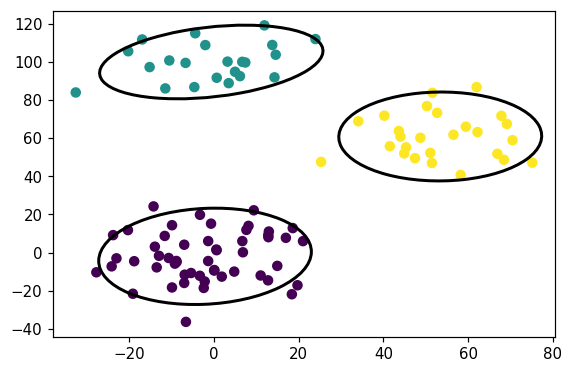

In [9]:
plot_gmm(data, gmm)

We can also visualise how the 2D feature space is partitioned into clusters.

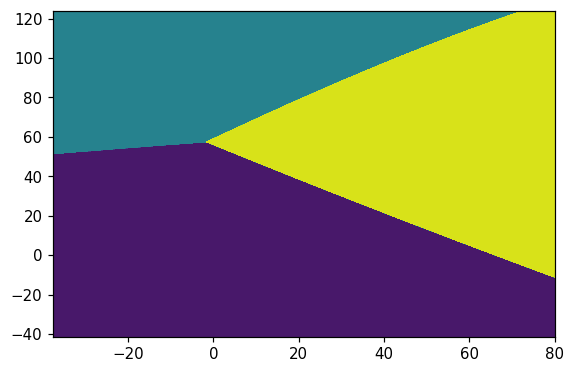

In [10]:
res = 0.1   # grid resolution
border = 5  # grid border

x0_lower = np.min(data[:,0]) - border
x0_upper = np.max(data[:,0]) + border
x1_lower = np.min(data[:,1]) - border
x1_upper = np.max(data[:,1]) + border

x0, x1 = np.mgrid[x0_lower:x0_upper:res, x1_lower:x1_upper:res]
grid = np.c_[x0.ravel(), x1.ravel()]
cluster = gmm.predict(grid).reshape(x0.shape)

plt.contourf(x0, x1, cluster)
plt.show()

Let's see what happens if we specify the "wrong" number of clusters.

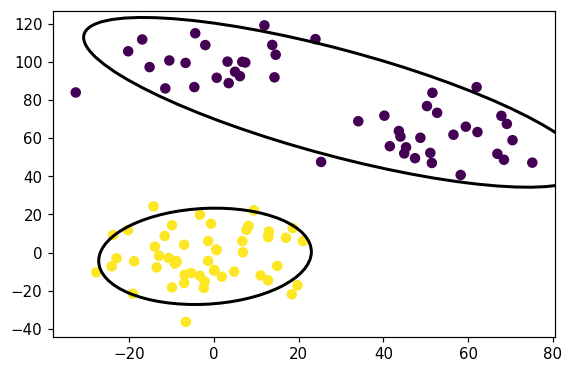

In [11]:
gmm_2 = GaussianMixture(n_components=2, covariance_type='full').fit(data)
plot_gmm(data, gmm_2)

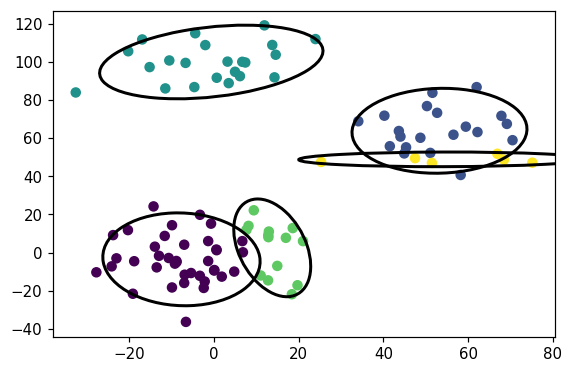

In [12]:
gmm_5 = GaussianMixture(n_components=5, covariance_type='full').fit(data)
plot_gmm(data, gmm_5)

***
**Exercise:** Repeat this section for different synthetic datasets, e.g. with overlapping clusters.
***

### 3. Tuning the number of clusters

In the previous section, we saw that it's important to select an appropriate value for $k$—i.e. GMM is not reslient to misspecified $k$.

We'll now review the following methods for selecting $k$:
1. **Log-likelihood based.** Requires held-out data. Can be computed for a data matrix `X` using `gmm.score(X)`.
2. **AIC.** [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion). Can be computed for a data matrix `X` using `gmm.aic(X)`.
3. **BIC.** [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion). Can be computed for a data matrix `X` using `gmm.bic(X)`.

But first, let's generate a more complicated data set with a larger number of clusters. Note that we partition the data into train/validation so that we can apply the first method above.

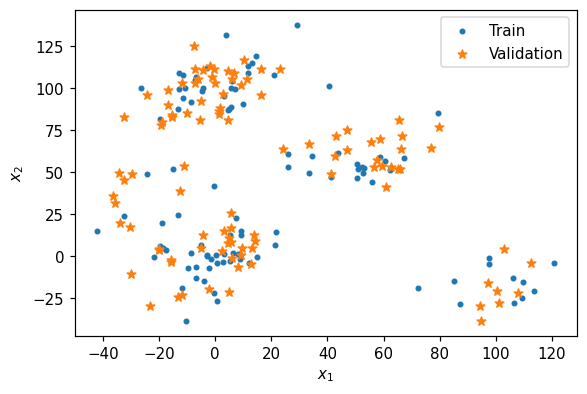

In [13]:
weights = np.array([0.3, 0.2, 0.3, 0.1, 0.1])

means = np.array([[0, 0], 
                  [50, 60], 
                  [0, 100], 
                  [100, -20], 
                  [-20, 40]])

covariances = np.array([[[160, 20], [20, 180]], 
                        [[170, 30], [30, 120]], 
                        [[130, 40], [40, 130]], 
                        [[130, 40], [40, 130]], 
                        [[130, 40], [40, 130]]])

data = generate_gmm_data(200, weights, means, covariances)

train_data, validation_data = train_test_split(data, test_size=0.5)

plt.scatter(train_data[:,0], train_data[:,1], marker='.', label='Train')
plt.scatter(validation_data[:,0], validation_data[:,1], marker='*', label='Validation')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In the code block below, you should fit a GMM for each value of $k \in \{1,\ldots, 10\}$ and compute:
* `train_ll`: log-likelihood on the training set
* `validation_ll`: log-likelihood on the validation set
* `aic`: AIC on the training set
* `aic_corrected`: corrected AIC (defined below) on the training set
* `bic`: BIC on the training set
* `n_parameters`: number of free parameters in the model

Note that in practice it's recommended to use corrected AIC for small sample sizes. It's defined as 
$$
\mathrm{AICc} = \mathrm{AIC} + \frac{2 n_{\mathrm{par}} (n_{\mathrm{par}}+1)}{n-n_{\mathrm{par}}-1}
$$
where $n_{\mathrm{par}}$ is the number of free parameters, and $n$ is the number of data points.

In [14]:
range_k = np.arange(1, 10, dtype=int)
n_instances = data.shape[0]

# Arrays to hold quantities for each k
train_ll = np.zeros(range_k.size)
validation_ll = np.zeros(range_k.size)
aic = np.zeros(range_k.size)
aic_corrected = np.zeros(range_k.size)
bic = np.zeros(range_k.size)
n_parameters = np.zeros(range_k.size)

for i,k in enumerate(range_k):
    # your code here #
    gmm_full = GaussianMixture(n_components=k, covariance_type='full').fit(data)
    gmm_cv = GaussianMixture(n_components=k, covariance_type='full').fit(train_data)
    train_ll[i] = gmm_cv.score(train_data)
    validation_ll[i] = gmm_cv.score(validation_data)
    aic[i] = gmm_full.aic(data)
    bic[i] = gmm_full.bic(data)
    n_parameters[i] = k*(1 + 2 + 3) - 1
    aic_corrected[i] = aic[i] + 2*n_parameters[i]*(n_parameters[i] + 1) / (n_instances - n_parameters[i] - 1)

Now plot all these quantities as a function of $k$. 

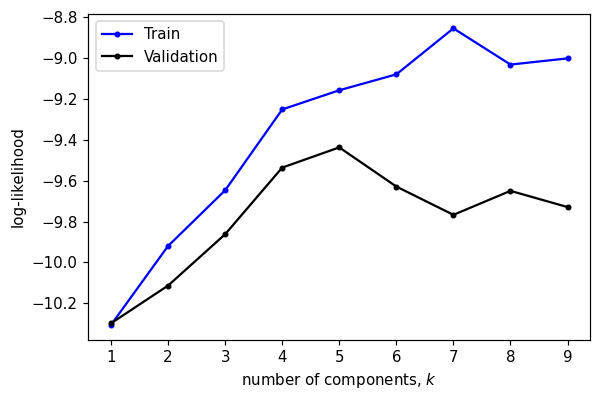

In [15]:
plt.plot(range_k, train_ll, 'b.-', label = 'Train')
plt.plot(range_k, validation_ll, 'k.-', label = 'Validation')
plt.xlabel('number of components, $k$')
plt.ylabel('log-likelihood')
plt.legend()
plt.show()

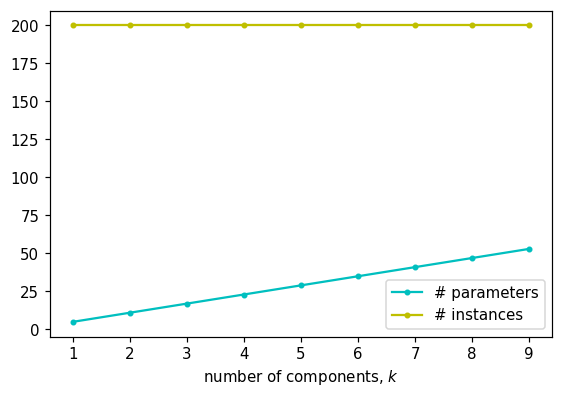

In [16]:
plt.plot(range_k, n_parameters, 'c.-', label = '# parameters')
plt.plot(range_k, np.full_like(n_parameters, n_instances), 'y.-', label = '# instances')
plt.xlabel('number of components, $k$')
plt.legend()
plt.show()

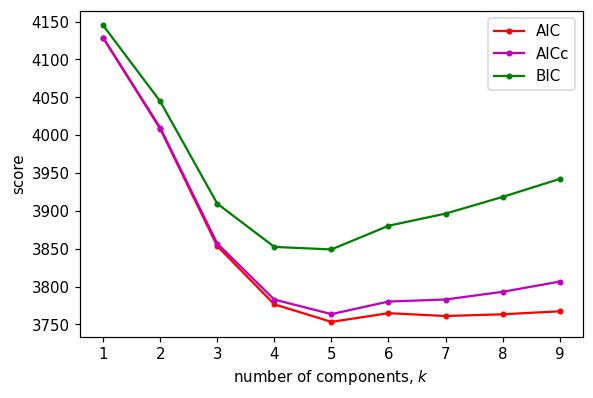

In [17]:
plt.plot(range_k, aic, 'r.-', label='AIC')
plt.plot(range_k, aic_corrected, 'm.-', label='AICc')
plt.plot(range_k, bic, 'g.-', label='BIC')
plt.xlabel('number of components, $k$')
plt.ylabel('score')
plt.legend()
plt.show()

***
**Question:** Analyse the resulting plots. What can you tell about the number of parameters? Can all of these quantities be used to estimate the number of clusters?

**Answer:** *The plots will vary due to randomisation. 
Ideally, you should see the validation log-likelihood plateauing at around $k=5$. 
This indicates that for $k$ beyond this value, the model is overfitting.
For AICc and BIC, we expect to see a minimum at around $k=5$.
At this value of $k$, the relative information loss is expected to be minimal among all $k$.*
***

### 4. Extension: exploring the connection between GMMs and k-means clustering

In lectures we saw that inference for a GMM can be performed using the expectation-maximisation (EM) algorithm. It is a coordinate ascent algorithm, which alternates between the following two steps:

* **E-step:** Update the cluster responsibilities given the estimates of the model parameters at the $t$-th step $\theta^{(t)} = (w_1^{(t)}, \boldsymbol{\mu}_1^{(t)}, \boldsymbol{\Sigma}_1^{(t)}, \ldots, w_k^{(t)}, \boldsymbol{\mu}_k^{(t)}, \boldsymbol{\Sigma}_k^{(t)})$:
$$
r_{ic}^{(t + 1)} = p(z_i = c|\mathbf{x}_i, \theta^{(t)}) = \frac{w_c^{(t)} \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_c^{(t)}, \boldsymbol{\Sigma}_c^{(t)})}{\sum_{c'=1}^{k} w_{c'}^{(t)} \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_{c'}^{(t)}, \boldsymbol{\Sigma}_{c'}^{(t)})}
$$

* **M-step:** Update the model parameters using the estimates of the cluster responsibilities at step $t+1$:
$$
\begin{align}
w_c^{(t+1)} &= \frac{\sum_{i = 1}^{n} r_{ic}^{(t)}}{n} \\
\boldsymbol{\mu}_c^{(t+1)} &= \frac{\sum_{i = 1}^{n} r_{ic}^{(t + 1)} \mathbf{x}_i}{\sum_{i = 1}^{n} r_{ic}^{(t)}} \\
\boldsymbol{\Sigma}_c^{(t+1)} &= \frac{\sum_{i = 1}^{n} r_{ic}^{(t + 1)} \left(\mathbf{x}_i - \boldsymbol{\mu}_c^{(t+1)}\right) \left(\mathbf{x}_i - \boldsymbol{\mu}_c^{(t+1)}\right)^\top}{\sum_{i = 1}^{n} r_{ic}^{(t)}}
\end{align}
$$

***
**Exercise:** Consider a GMM where the covariance matrices for all components are _identical_ and _isotropic_, i.e. $\boldsymbol{\Sigma}_c = \varepsilon \mathbb{I}$ for all $c \in \{1, \ldots, k\}$ where $\mathbb{I}$ is the identity matrix and $\varepsilon > 0$ is a fixed parameter.
Show that the E- and M-steps for the GMM are equivalent to the k-means algorithm (a.k.a. the Lloyd–Forgy algorithm) in the limit $\varepsilon \to 0$.

**Solution:**

Let's simplify and evaluate the limit for the E-step first.
After substituting the PDF for a multivariate normal and cancelling the normalisation factors (since the covariance matrices are identical), we have: 
$$
r_{ic}^{(t + 1)} = \frac{w_c^{(t)} \exp \left(-\frac{1}{2\varepsilon^2} \|\mathbf{x}_i - \boldsymbol{\mu}_c^{(t)}\|_2^2 \right)}
    {\sum_{c'=1}^{k} w_{c'}^{(t)} \exp \left(-\frac{1}{2\varepsilon^2} \|\mathbf{x}_i - \boldsymbol{\mu}_{c'}^{(t)}\|_2^2 \right)}
$$

Let $d_{ic} = \|\mathbf{x}_i - \boldsymbol{\mu}_c^{(t)}\|_2$ be the Euclidean distance from data point $\mathbf{x}_i$ to cluster mean $\boldsymbol{\mu}_c$ (dropping dependence on $t$), and let $\tilde{d}_i$ be the distance to the closest cluster $\tilde{c}_i = \arg \min_c d_{ic}$.
Multiplying and dividing the previous equation by $\exp (\tilde{d}_{i}^2 / 2\varepsilon^2 )$, we have:
$$
r_{ic}^{(t + 1)} = \frac{w_c^{(t)} \exp \left(\frac{\tilde{d}_{i}^2 - d_{ic}^2}{2\varepsilon^2} \right)}
    {\sum_{c'=1}^{k} w_{c'}^{(t)} \exp \left(\frac{\tilde{d}_{i}^2 - d_{ic'}^2}{2\varepsilon^2} \right)}
    = \frac{w_c^{(t)} \exp \left(\frac{\Delta_{ic}^2}{2\varepsilon^2} \right)}
    {\sum_{c'=1}^{k} w_{c'}^{(t)} \exp \left(\frac{\Delta_{ic'}^2}{2\varepsilon^2} \right)}
$$
where we define $\Delta_{ic} = \tilde{d}_{i}^2 - d_{ic}^2$. 
Notice that $\Delta_{ic} < 0$ if $d_{ic} \neq \tilde{d}_{i}$ and $\Delta_{ic} = 0$ if $\tilde{d}_{i} = d_{ic}$.
Thus 
$$
\begin{align*}
r_{ic}^{(t + 1)} &= \begin{cases}
    w_c^{(t)} \exp \left(\frac{\Delta_{ic}^2}{2\varepsilon^2} \right) / \left(w_{\tilde{c}_i}^{(t)} + \sum_{c'\neq \tilde{c}_i}^{k} w_{c'}^{(t)} \exp \left(\frac{\Delta_{ic'}^2}{2\varepsilon^2} \right) \right), & d_{ic} \neq \tilde{d}_{i}\\
    w_c^{(t)} / \left(w_c^{(t)} + \sum_{c'\neq c} w_{c'}^{(t)} \exp \left(\frac{\Delta_{ic'}^2}{2\varepsilon^2} \right) \right), & d_{ic} = \tilde{d}_{i}\\
\end{cases}\\
    &\to \begin{cases}
    0, & d_{ic} \neq \tilde{d}_{i}\\
    1, & d_{ic} = \tilde{d}_{i}\\
\end{cases} \quad \mathrm{as} \ \varepsilon \to 0
\end{align*}
$$
This means the E-step will yield a "hard" cluster responsibility $r_{ic} = \mathbb{1}[c = \tilde{c}_i]$ - a point mass at the closest cluster $\tilde{c}_i$, just like the k-means algorithm.

Next we consider the M-step. 
The covariance matrices $\{\Sigma_c\}$ are known, so they don't need to be updated.
We can also remove the cluster weights, since they are not used in the E-step, and they do not appear in the update for the cluster means.
Turning to the update for the cluster means, we have:
$$
\boldsymbol{\mu}_c^{(t+1)} = \frac{\sum_{i = 1}^{n} \mathbb{1}[c = \tilde{c}_i] \mathbf{x}_i}{\sum_{i = 1}^{n} \mathbb{1}[c = \tilde{c}_i]}
$$
This is the centroid for cluster $c$, based on those items "assigned" to it in the E-step. 
It is identical to the centroid update step in the k-means algorithm.
***